# Comparing semantle solvers and similarity models

Compare solvers with a sequence of guesses from people

In [1]:
from english_words import english_words_set
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import semantle_simulator as ss
import similarity_model as sm
import gradient_solver as gs
import cohort_bayes_solver as cbs

## Simulator for semantle

In [2]:
sem_sim = ss.SemantleSimulator()

In [3]:
sem_sim.target = 'terrible'

## Guesses from people

In [4]:
friend_df = pd.read_csv('data/friends_guesses.csv')

## Agent similarity model

In [5]:
base_vocabulary = english_words_set
if sem_sim.target not in base_vocabulary:
    base_vocabulary.add(sem_sim.target)
    
#similarity = sm.SimilarityModelW2V(sem_sim.wv, base_vocabulary)
similarity = sm.SimilarityModelUSE(base_vocabulary)

2022-07-21 14:44:17.085502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualise the results

In [6]:
def simulator_sh(gh, simulator, model):
    return np.array([simulator.score_guess(model.word_string(g)) for g in gh])

In [7]:
def simulator_sh_string(gh, simulator, model):
    return np.array([simulator.score_guess(g) for g in gh])

In [8]:
def plot_calibration(ax, count, simulator):
    tgt_cal = simulator.score_calibration()
    ax.plot([0, count], [tgt_cal[0][1], tgt_cal[0][1]], '--', c='lightgrey')
    ax.text(0, tgt_cal[0][1] + 2, 'nearest', c='grey') 
    ax.plot([0, count], [tgt_cal[1][1], tgt_cal[1][1]], '--', c='lightgrey')
    ax.text(0, tgt_cal[1][1] + 2, 'approx tenth nearest', c='grey') 
    ax.plot([0, count], [tgt_cal[2][1], tgt_cal[2][1]], '--', c='lightgrey')
    ax.text(0, tgt_cal[2][1] + 2, 'approx thousandth nearest', c='grey') 

In [9]:
def plot_guesses(gh, sh, ax, labels=False, c='turquoise'):
    el, = ax.plot(sh, c=c)
    if labels:
        for i, g in enumerate(gh):
            ax.text(i, sh[i] + 2, g, c=c) 
    return el

## Solvers complete from initial guesses

In [10]:
def merge_guesses(solver, guesses, scores=None):
    unmerged = []
    for i, gw in enumerate(guesses):
        if gw in similarity.vocabulary:
            guess_index = similarity.word_index(gw)
            score = scores[i] if scores is not None else sem_sim.score_guess(gw)
            solver.merge_guess(guess_index, score, sem_sim.score_scaling)
        else:
            unmerged.append(i)
    return unmerged

In [11]:
cohort_bayes = cbs.CohortBayesSolver(similarity, precision=0.1, recall=1, log=True)
merge_guesses(cohort_bayes, friend_df['guess'][:10])

[0, 1, 8, 9]

In [12]:
target, steps = cohort_bayes.solve(sem_sim)
print(f'semantle target "{sem_sim.target}"')
print(f'solver reached "{similarity.word_string(target)}" (id {target}) in {steps} steps')

semantle target "terrible"
solver reached "terrible" (id 19159) in 51 steps


In [13]:
gradient = gs.GradientSolver(similarity, seeds=0, log=True)
merge_guesses(gradient, friend_df['guess'][:10])

[0, 1, 8, 9]

In [14]:
target, steps = gradient.solve(sem_sim)
print(f'semantle target "{sem_sim.target}"')
print(f'solver reached "{similarity.word_string(target)}" (id {target}) in {steps} steps')

semantle target "terrible"
solver reached "terrible" (id 19159) in 91 steps


## Visualise together

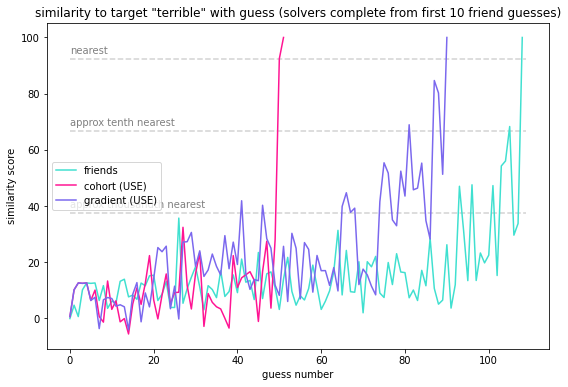

In [15]:
plt.figure(figsize=(9, 6))
cbs_gh = cohort_bayes.logging['guess']
gs_gh = gradient.logging['guess']
max_guesses = max(len(friend_df.index), len(cbs_gh), len(gs_gh))
plot_calibration(plt.gca(), max_guesses, sem_sim)
friend_line = plot_guesses(friend_df['guess'], friend_df['score'], plt.gca())
cohort_line = plot_guesses(cbs_gh, simulator_sh(cbs_gh, sem_sim, similarity), plt.gca(), c='deeppink')
gradient_line = plot_guesses(gs_gh, simulator_sh(gs_gh, sem_sim, similarity), plt.gca(), c='mediumslateblue')
plt.title(f'similarity to target "{sem_sim.target}" with guess (solvers complete from first 10 friend guesses)')
plt.ylabel('similarity score')
plt.xlabel('guess number')
sdes = similarity.description
plt.legend([friend_line, cohort_line, gradient_line], ['friends', f'cohort ({sdes})', f'gradient ({sdes})'])
plt.show()

## Solvers make just next guess

In [16]:
def solver_next_guesses(solver, guesses, scores=None):
    next_guesses = []
    unmerged = []
    for i, gw in enumerate(guesses):
        if gw in similarity.vocabulary:
            gi = similarity.word_index(gw)
            score = scores[i] if scores is not None else sem_sim.score_guess(gw)
            solver.merge_guess(gi, score, sem_sim.score_scaling)
        else:
            unmerged.append(gw)
        ng = similarity.word_string(solver.make_guess())
        next_guesses.append(ng)
        if ng == sem_sim.target:
            break
    return next_guesses, unmerged

In [17]:
cohort_bayes = cbs.CohortBayesSolver(similarity, log=True)
next_guesses_cbs, unmerged_cbs = solver_next_guesses(cohort_bayes, friend_df['guess'], scores=friend_df['score'])

In [18]:
gradient = gs.GradientSolver(similarity, seeds=0, log=True)
next_guesses_gs, unmerged_gs = solver_next_guesses(gradient, friend_df['guess'], scores=friend_df['score'])

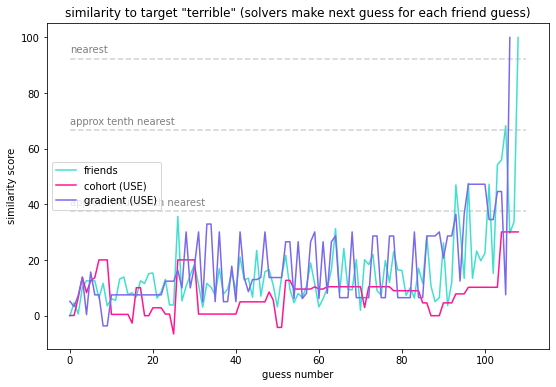

In [19]:
plt.figure(figsize=(9, 6))
plot_calibration(plt.gca(), 110, sem_sim)
friend_line = plot_guesses(friend_df['guess'], friend_df['score'], plt.gca())
cohort_line = plot_guesses(next_guesses_cbs, simulator_sh_string(next_guesses_cbs, sem_sim, similarity), plt.gca(), c='deeppink')
gradient_line = plot_guesses(next_guesses_gs, simulator_sh_string(next_guesses_gs, sem_sim, similarity), plt.gca(), c='mediumslateblue')
plt.title(f'similarity to target "{sem_sim.target}" (solvers make next guess for each friend guess)')
plt.ylabel('similarity score')
plt.xlabel('guess number')
sdes = similarity.description
plt.legend([friend_line, cohort_line, gradient_line], ['friends', f'cohort ({sdes})', f'gradient ({sdes})'])
plt.show()